In [ ]:
#| default_exp laziness_decay
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 02a Laziness Decay
> Tracking laziness over time

Here we get the dataset set up and define the laziness decay function.

In [ ]:
import diffusion_curvature # our main package
from diffusion_curvature.core import plot_3d, DiffusionMatrix
from diffusion_curvature.laziness import *
from diffusion_curvature.local_laziness import *
from diffusion_curvature.datasets import torus
import numpy as np
import matplotlib.pyplot as plt

Let's establish our tried and true dataset, the *torus*!

In [ ]:
X, ks = torus(n=5000,seed=42)
P = DiffusionMatrix(X,kernel_type='adaptive anisotropic',k=20)
# the hyperparameters here are the kernel type and the kernel bandwidth. I've chosen them by hand to work well.

In [ ]:
#| export
import numpy as np
from tqdm.notebook import trange
from diffusion_curvature.laziness import *
from diffusion_curvature.local_laziness import *
def laziness_decay(A, max_steps = 32, aperture = 20, neighborhood=10, smoothing=1, adaptive_neighborhood = False, non_lazy_diffusion=False,use_local_laziness=False):
    """Generates a matrix of the decaying laziness value per point over a range of t values

    Parameters
    ----------
    P : ndarray
        Diffusion matrix
    max_steps : int, optional
        Number of diffusion steps to take (starting from 1), by default 32
    aperture : int, optional
        The size of the initial diffusion neighborhood, by default 20
    smoothing : int, optional
        Number of smmoothing interations, by default 1

    Returns
    -------
    ndarray
        Each column is a set of laziness values per point at a specific time.
    """    
    if A.sum(axis=1)[0]==1:
        print("You seem to have passed the diffusion matrix. Skipping row normalization.")
        P = A
    else:
        D = np.diag(1/np.sum(A,axis=1))
        P = D @ A
    decay_per_point = np.empty((len(P),max_steps))
    if non_lazy_diffusion:
        print("Removing self-diffusion")
        P_zero_diagonal = (np.ones_like(P) - np.diag(np.ones(len(P))))*P
        D = np.diag(1/np.sum(P_zero_diagonal,axis=0))
        P = D @ P_zero_diagonal
    P_t = P
    for t in trange(1,max_steps+1):
        if use_local_laziness:
            laziness = local_laziness(A,diffusion_powers = t,aperture=aperture,neighborhood=neighborhood,smoothing=1)
        else:
            P_t = P_t @ P
            laziness = curvature(P,diffusion_powers=t,aperture=aperture,precomputed_powered_P=P_t,smoothing=smoothing,dynamically_adjusting_neighborhood=adaptive_neighborhood, non_lazy_diffusion=non_lazy_diffusion)
        decay_per_point[:,t-1] = laziness
    return decay_per_point

In [ ]:
show_doc(laziness_decay)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/master/diffusion_curvature/laziness_decay.py#L11){target="_blank" style="float:right; font-size:smaller"}

### laziness_decay

>      laziness_decay (A, max_steps=32, aperture=20, neighborhood=10,
>                      smoothing=1, adaptive_neighborhood=False,
>                      non_lazy_diffusion=False, use_local_laziness=False)

Generates a matrix of the decaying laziness value per point over a range of t values

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| A |  |  |  |
| max_steps | int | 32 | Number of diffusion steps to take (starting from 1), by default 32 |
| aperture | int | 20 | The size of the initial diffusion neighborhood, by default 20 |
| neighborhood | int | 10 |  |
| smoothing | int | 1 | Number of smmoothing interations, by default 1 |
| adaptive_neighborhood | bool | False |  |
| non_lazy_diffusion | bool | False |  |
| use_local_laziness | bool | False |  |
| **Returns** | **ndarray** |  | **Each column is a set of laziness values per point at a specific time.** |

Such a small function! But such power!
Let's test it on the donut.
It will also be informative to see how long it takes.

  0%|          | 0/32 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D>]

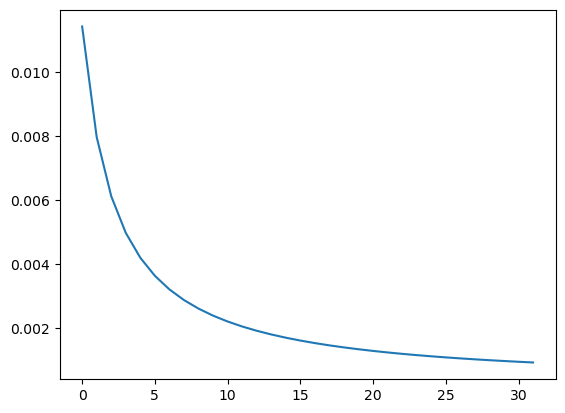

In [ ]:
decaying_lazy = laziness_decay(P, max_steps=32,aperture=20, adaptive_neighborhood=True)
plt.plot(decaying_lazy[0])

These laziness decay plots look just as one would expect: the laziness decays. But does it decay differently in different regions? For this, we need to identify the indices of some points on the donut.

The torus function has been set up and so that the 0th point is on the outer rim, in a region of high positive curvature. The 1st point is in the inside, in a region of negative curvature, and the 2nd point is on the top, where the curvature should be closer to zero.

But let's first verify that the laziness is tracking with the curvature here.

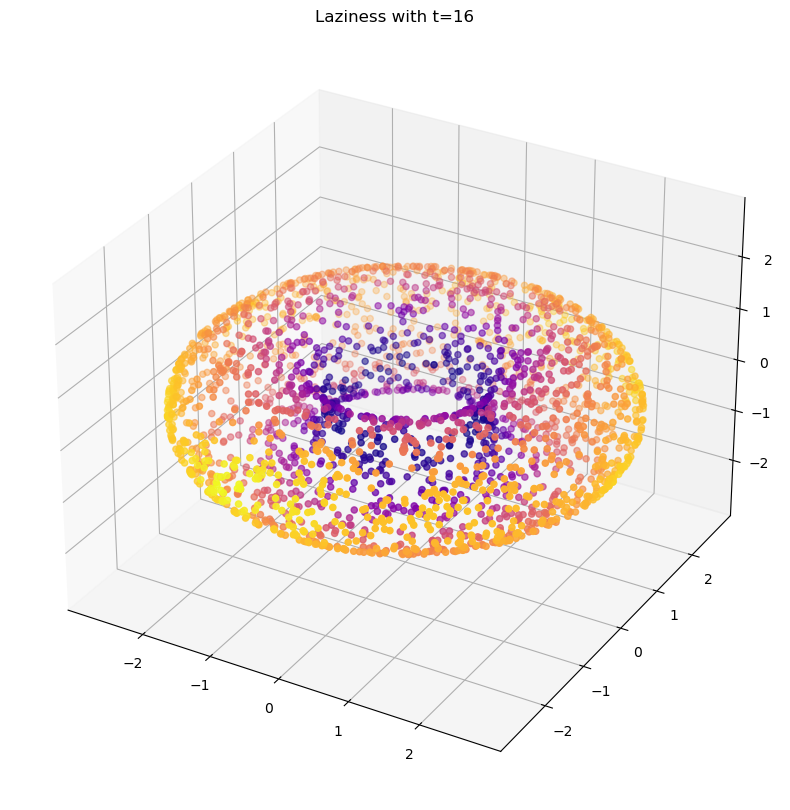

In [ ]:
plot_3d(X,decaying_lazy[:,16],title="Laziness with t=16")

In [ ]:
plot_3d(X,decaying_lazy[:,16],title="Laziness with t=16",use_plotly=True)

Let's visualize our target points:

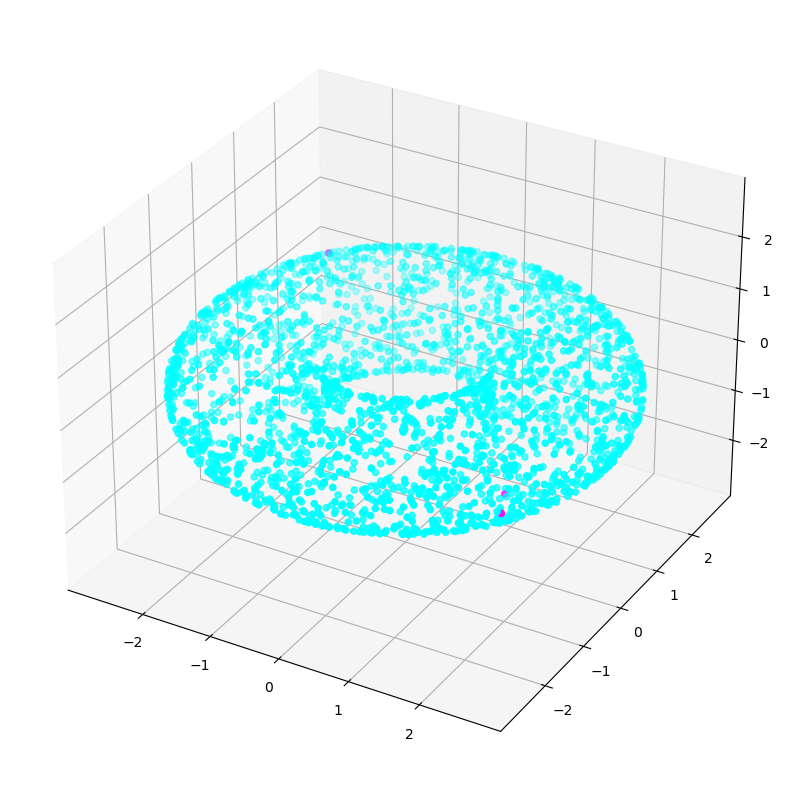

In [ ]:
dist = np.zeros(len(X))
dist[0] = 1
dist[1] = 1
dist[2] = 1
plot_3d(X,dist,cmap="cool")

# Decay Graphs, with minimal smoothing

At last, we can draw a laziness decay graph!

Text(0, 0.5, 'Laziness')

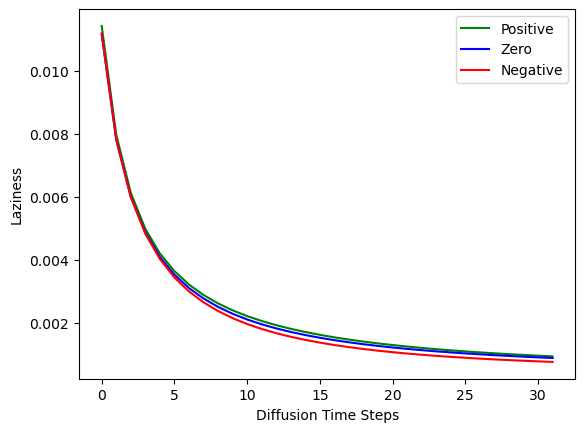

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(decaying_lazy[0],color='green',label='Positive')
ax.plot(decaying_lazy[2],color='blue',label='Zero')
ax.plot(decaying_lazy[1],color='red',label='Negative')
ax.legend()
ax.set_xlabel("Diffusion Time Steps")
ax.set_ylabel("Laziness")

As expected, the point of negative curvature decays fastest, and the positively curved point is the most leisurely.

This graph also illustrates the diffusion time steps which optimally emphasize the contrast between these points. Anywhere from 7 to 20 appears reasonable.